# Semi Supervised Learning Normalising Flow 

Here we aim to get probability memberships for stars in a cluster based on a semi supevised learning method. The method uses the GMM Flow model. We use stars as classified with extreme high probabiliity from the XDGMM model to label data as beign in the cluster. Moreover we use best isochrone fit to to find more stars which are almost perfect fits. Importantlly we also use this information to label stars which are almost definitely not in the cluster and are field stars. From here we use this information to do a Semi Supervised fit using the GMM Flow

In [29]:
from astropy.io import fits
import os

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import sklearn.decomposition
import seaborn as sn
import pickle
if("Cluster_analysis" in os.getcwd()):
    os.chdir("../Data_handling")

from nf_norm import FlowGMM
from gaia_query import gaia_cone, bailer_jones_cone, concatenate_gaia_bailer
from vae import Encoder,Decoder, VAE , loss_function, model_train
from sp_vae import ModelVAE,model_trains
from gmm_torch import GaussianMixture

os.chdir("../Cluster_analysis")
os.getcwd()

'/Users/mattocallaghan/GES/Cluster_analysis'

In [30]:
sn.set_style('darkgrid') # darkgrid, white grid, dark, white and ticks
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=13)    # fontsize of the tick labels
plt.rc('ytick', labelsize=13)    # fontsize of the tick labels
plt.rc('legend', fontsize=13)    # legend fontsize
plt.rc('font', size=13)  

### Import Data

In [31]:
os.chdir('../cluster_files')
nf_data=pd.read_csv('vae_data.csv')
os.chdir('../Cluster_analysis')

/var/folders/v8/qszwt8g90wj00vpb5s08vpdw0000gn/T/ipykernel_37246/3296965813.py:2: DtypeWarning: Columns (11,12,15,16,17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  nf_data=pd.read_csv('vae_data.csv')


### Parameters of Interest

In [32]:
columns=['ra','dec','parallax','VRAD','pmra','pmdec','bp_g','g_rp',
'ra_error','dec_error','parallax_error','pmra_error','pmdec_error','phot_g_mean_flux'
,'mean_absolute_mag_g_band','bp_rp','prob'
,'parallax_over_error','phot_g_mean_flux_error','phot_bp_mean_flux_error','phot_rp_mean_flux_error'
,'phot_g_mean_flux_over_error','phot_bp_mean_flux_over_error','phot_rp_mean_flux_over_error','rgeo','phot_g_mean_mag','mag_error']


In [33]:
nf_data['mag_error']=(2.5/np.log(10.0))*(1.0/nf_data['phot_g_mean_flux_over_error']).values

In [34]:
nf_data

,Unnamed: 0.1,index,ra,dec,rgeo,VRAD,pmra,pmdec,prob,level_0,...,DE_ICRS,b_rgeo,B_rgeo,rpgeo,b_rpgeo,B_rpgeo,Flag,mean_absolute_mag_g_band,prob_other,mag_error
0,0,0,282.565031,-6.258065,1.942982,30.64,0.776237,-6.756839,2.996315e-104,0,...,-6.258065,1618.71545,2489.67163,1923.29565,1666.32056,2345.46167,10033,20.377983,1.595858e-101,0.001007
1,1,1,282.583418,-6.192254,6.141484,105.47,-1.612175,-4.640347,1.528117e-124,1,...,-6.192254,3163.27856,10115.85840,3446.87402,2693.09326,5311.75977,10033,18.869186,8.002693e-94,0.002122
2,2,2,282.592885,-6.329504,2.671463,39.07,-2.393408,-4.043109,6.214352e-05,2,...,-6.329504,2193.52368,3324.61035,2677.84912,2291.58057,3349.83423,10033,19.753740,4.064911e-04,0.000907
3,3,3,282.596724,-6.241452,1.887643,-43.21,-3.040533,-0.931751,0.000000e+00,3,...,-6.241452,1726.50842,2108.31055,1788.85913,1661.42944,1947.09448,10033,19.844798,4.001364e-250,0.000623
4,4,4,282.596739,-6.257442,2.360141,-5.76,-0.711199,-4.404408,5.844602e-58,4,...,-6.257442,2176.29297,2672.13403,2255.69653,2041.00903,2474.74609,10033,19.017714,9.445452e-41,0.000500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25777,25777,25777,282.788470,-6.007469,7.084011,0.00,-2.850967,-5.665195,4.696035e-46,24803,...,-6.007469,4910.56494,9565.59473,6045.83057,4184.62695,8731.06445,10033,18.015978,5.792929e-47,0.001843
25778,25778,25778,282.780248,-6.007047,2.100936,0.00,1.577184,3.119071,0.000000e+00,24804,...,-6.007047,1883.03979,2459.72168,2147.17578,1872.23279,2423.75122,10033,19.919543,0.000000e+00,0.000786
25779,25779,25779,282.775456,-6.005157,7.769465,0.00,-1.806624,-4.939151,2.367379e-29,24805,...,-6.005157,5965.04639,11243.42680,10565.55080,5788.68164,16626.45700,10133,17.587664,1.275497e-30,0.001092
25780,25780,25780,282.703295,-6.011748,4.963540,0.00,-3.147602,-4.699169,1.038220e-23,24806,...,-6.011748,3545.60669,6594.21533,3321.26025,2547.17358,4331.92773,10033,18.746492,9.985219e-24,0.001151


In [35]:
nf_data=nf_data[columns].dropna().reset_index(drop=True)

# Semi Supervised Learning Labelling

We are going to choose stars with the XGDM prob < 1e-50 to be field stars.
We will choose stars with prob >0.999 as being cluster stars

In [36]:
nf_data['l1']=nf_data['prob']>=0.99
nf_data['l2']=nf_data['prob']<1e-50

In [37]:
nf_data['l2'].sum()
nf_data[['l1','l2']]=nf_data[['l1','l2']].astype(int)
nf_data=nf_data.reset_index()
nf_data['l3']=nf_data['l1'] + nf_data['l2']-1
nf_data['labels']=0*nf_data['l1']+nf_data['l2']*1+nf_data['l3']

In [38]:
nf_data

,index,ra,dec,parallax,VRAD,pmra,pmdec,bp_g,g_rp,ra_error,...,phot_g_mean_flux_over_error,phot_bp_mean_flux_over_error,phot_rp_mean_flux_over_error,rgeo,phot_g_mean_mag,mag_error,l1,l2,l3,labels
0,0,282.565031,-6.258065,0.558562,30.64,0.776237,-6.756839,0.590866,0.740053,0.062462,...,1077.94260,123.194890,223.189440,1.942982,16.820326,0.001007,0,1,0,1
1,1,282.583418,-6.192254,0.376980,105.47,-1.612175,-4.640347,0.413675,1.044496,0.116390,...,511.61658,34.331070,31.203371,6.141484,17.810553,0.002122,0,1,0,1
2,2,282.592885,-6.329504,0.375033,39.07,-2.393408,-4.043109,0.575531,0.677193,0.061189,...,1197.15140,168.404950,228.644740,2.671463,16.887486,0.000907,0,0,-1,-1
3,3,282.596724,-6.241452,0.523459,-43.21,-3.040533,-0.931751,0.585712,0.756983,0.043225,...,1742.58020,168.069720,457.864930,1.887643,16.224398,0.000623,0,1,0,1
4,4,282.596739,-6.257442,0.395225,-5.76,-0.711199,-4.404408,0.529069,0.704749,0.036199,...,2172.79220,385.859700,567.223450,2.360141,15.882403,0.000500,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24570,24570,282.788470,-6.007469,0.030766,0.00,-2.850967,-5.665195,0.790930,0.894377,0.082114,...,589.08026,84.467860,179.946430,7.084011,17.267374,0.001843,0,0,-1,-1
24571,24571,282.780248,-6.007047,0.449862,0.00,1.577184,3.119071,0.720057,0.885668,0.057465,...,1381.98470,193.339860,258.442700,2.100936,16.531607,0.000786,0,1,0,1
24572,24572,282.775456,-6.005157,0.002803,0.00,-1.806624,-4.939151,1.733685,1.229452,0.071895,...,994.19196,68.978790,370.094400,7.769465,17.039620,0.001092,0,0,-1,-1
24573,24573,282.703295,-6.011748,0.209325,0.00,-3.147602,-4.699169,0.667429,0.838211,0.090482,...,943.16860,101.536180,145.135670,4.963540,17.225449,0.001151,0,0,-1,-1


In [39]:
nf_data=nf_data.sample(frac=1).reset_index(drop=True) #shuffles

In [40]:

x=nf_data[nf_data['l1']==True].sample(n=5000, random_state=1,replace=True).reset_index()
nf_orig=nf_data
#nf_data=x
#nf_data=pd.concat([nf_data,x]).reset_index(drop=True)

# Error analysis for the input data

In [41]:
def sigma_clip(parameter,data,sigma_weight):
    med=data[parameter].median()
    std=data[parameter].std()
    data=(data[data[parameter]<med+sigma_weight*std]).reset_index(drop=True)
    data=(data[data[parameter]>med-sigma_weight*std]).reset_index(drop=True)

In [42]:
#sigma_clip('mag_error',nf_data,3.0)


Should we expect flux values massively above

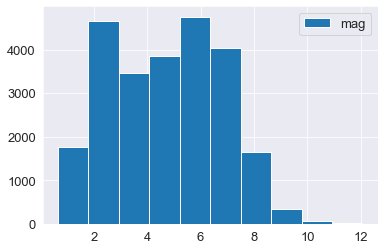

In [43]:
nf_data=nf_data[nf_data['phot_g_mean_mag']<1e5].reset_index(drop=True)
plt.hist(nf_data['rgeo'],label='mag')
#plt.plot(nf_data['mag_error'],label='error')
plt.legend()
plt.show()

In [44]:
nf_data=nf_data[nf_data['rgeo']<=5000].reset_index(drop=True)
nf_data=nf_data[nf_data['phot_g_mean_flux_error']<1000].reset_index(drop=True)
nf_data=nf_data[nf_data['phot_bp_mean_flux_error']<1000].reset_index(drop=True)
nf_data=nf_data[nf_data['phot_rp_mean_flux_error']<1000].reset_index(drop=True)
nf_data=nf_data[nf_data['pmra_error']<=0.45].reset_index(drop=True)
nf_data=nf_data[nf_data['pmdec_error']<=0.45].reset_index(drop=True)
nf_data=nf_data[nf_data['parallax_error']<=0.2].reset_index(drop=True)

In [45]:
len(nf_data)

21363

# Semisupervised Model Definition

In [46]:
from sklearn.preprocessing import  MinMaxScaler
import torch
scaler=MinMaxScaler()
column_names=['pmra', 'pmdec',
       'rgeo','ra','dec']
#column_names=['ra','dec','pmra','pmdec','mean_absolute_mag_g_band','bp_g','g_rp','bp_rp']
#column_names=['mean_absolute_mag_g_band','bp_rp','ra','dec','rgeo','g_rp','pmra','pmdec']
column_names=['mean_absolute_mag_g_band','bp_rp','bp_g','g_rp','labels']
scaled_data=nf_data[column_names].values

In [47]:
batch_size = int(len(scaled_data)) #617 #factor for 1090
lr = 1e-3
epochs = 100

In [48]:
from torch.utils.data import DataLoader
# Define distribution. 
from sklearn import cluster, datasets, mixture
from sklearn.preprocessing import StandardScaler


X=DataLoader(torch.tensor(scaled_data).float(),batch_size=batch_size,drop_last=True) 
model = FlowGMM(layers=4,n_features=scaled_data[0].shape[-1]-1,mixture_components=2,hidden_dims=[500,25],d=3,means=None)

# Training hyperparameters.
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [49]:
plot_loss=[]
plotll=[]
plotdet=[]
# Iterate over the number of iterations.
model.train()

for epoch in range(epochs):    
        overall_loss = 0
        for batch_idx, x in enumerate(X):

            x = x.view(batch_size, len(x[0]))
            #x = x.to(DEVICE)
            
            optimizer.zero_grad()

            y,gmm,loss,log_l,determinant,ll,det = model(x)
            
            
            
            overall_loss += loss.item()
            
            loss.backward()
            optimizer.step()
            
        plot_loss.append(loss)   
        plotll.append(ll)  
        plotdet.append(det)   
        #print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (batch_idx*batch_size))
        print("ll: "+ str(ll))
        print("Overall Loss: ", overall_loss)
    
print("Finish!!")

ll: tensor(-5.9265, grad_fn=<MeanBackward0>)
Overall Loss:  5.62195348739624
ll: tensor(-5.8556, grad_fn=<MeanBackward0>)
Overall Loss:  5.51043701171875
ll: tensor(-5.7938, grad_fn=<MeanBackward0>)
Overall Loss:  5.407031059265137
ll: tensor(-5.7404, grad_fn=<MeanBackward0>)
Overall Loss:  5.311357021331787
ll: tensor(-5.6940, grad_fn=<MeanBackward0>)
Overall Loss:  5.221950054168701
ll: tensor(-5.6533, grad_fn=<MeanBackward0>)
Overall Loss:  5.137711048126221
ll: tensor(-5.6176, grad_fn=<MeanBackward0>)
Overall Loss:  5.05789852142334
ll: tensor(-5.5865, grad_fn=<MeanBackward0>)
Overall Loss:  4.982161998748779
ll: tensor(-5.5596, grad_fn=<MeanBackward0>)
Overall Loss:  4.910223960876465
ll: tensor(-5.5368, grad_fn=<MeanBackward0>)
Overall Loss:  4.84181022644043
ll: tensor(-5.5171, grad_fn=<MeanBackward0>)
Overall Loss:  4.775886535644531
ll: tensor(-5.5001, grad_fn=<MeanBackward0>)
Overall Loss:  4.711871147155762
ll: tensor(-5.4854, grad_fn=<MeanBackward0>)
Overall Loss:  4.649522

In [50]:
import matplotlib.pyplot as plt
for i in range (len(plot_loss)):
    plot_loss[i]=plot_loss[i].detach().numpy()
    plotll[i]=plotll[i].detach().numpy()
    plotdet[i]=plotdet[i].detach().numpy()

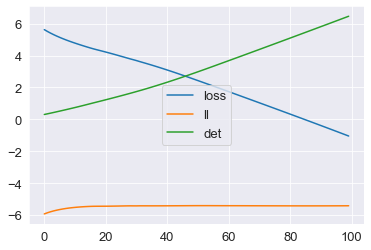

In [51]:
plt.plot(plot_loss,label='loss')
plt.plot(plotll,label='ll')
plt.plot(plotdet,label='det')
plt.legend()
plt.show()

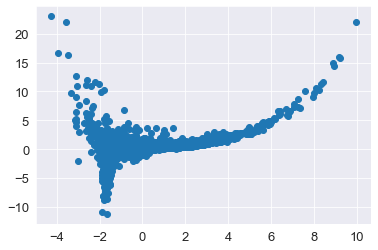

In [52]:

y,gmm,loss,log_l,determinant,ll,det = model(torch.tensor(scaled_data).float())
probs=gmm.log_prob(y).detach().numpy()
y=y.detach().numpy()

plt.scatter(y.transpose()[0],y.transpose()[1])

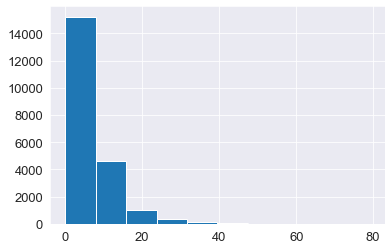

In [53]:
probs=np.exp(probs)*np.exp(determinant.detach().numpy())
plt.hist(probs.transpose())

plt.show()

In [54]:

df=pd.DataFrame(data=probs)
plotdf=pd.concat([nf_data,df],axis=1)


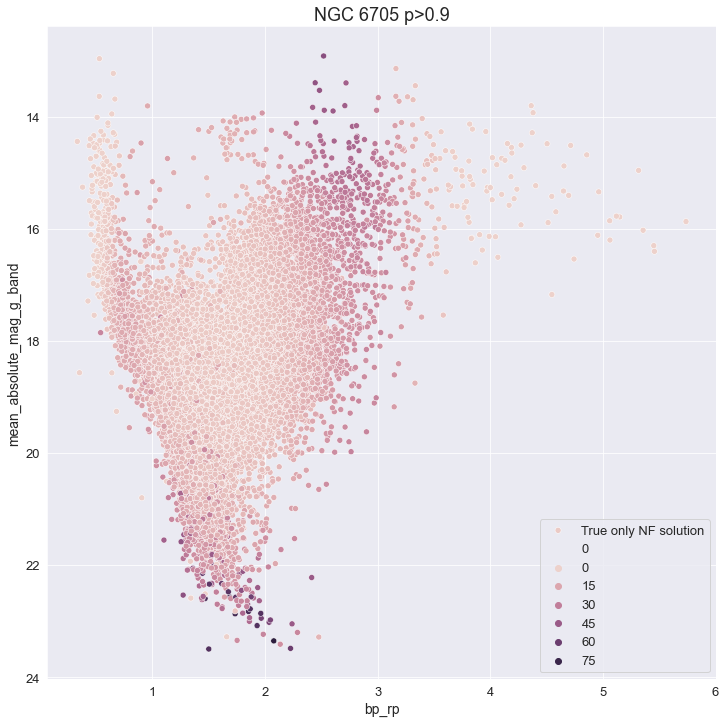

In [55]:
f, axes = plt.subplots(1, 1)
f.set_figheight(12)
f.set_figwidth(12)

scatter=plotdf
sn.scatterplot(x=scatter['bp_rp'],y=scatter['mean_absolute_mag_g_band'],hue=scatter[0],ax=axes,label='True only NF solution',color='b')

#axes.set_xlim(0,2.5)
axes.invert_yaxis()
plt.legend()
axes.set_title("NGC 6705 p>0.9")
plt.show()

In [56]:

p=0.90
data_for_hr1_full=plotdf[plotdf[j]>p]
data_for_hr2_full=plotdf[plotdf['prob']>p]
both_solution=data_for_hr1_full[data_for_hr1_full['prob']>p]

data_for_hr1_full=data_for_hr1_full[data_for_hr1_full['prob']<=p]
data_for_hr2_full=data_for_hr2_full[data_for_hr2_full[j]<=p]

NameError: name 'j' is not defined

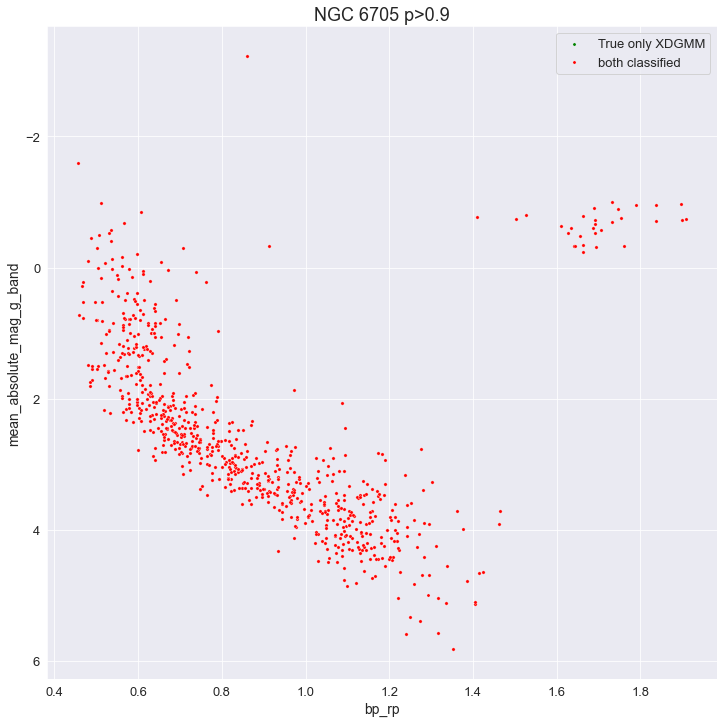

In [ ]:
f, axes = plt.subplots(1, 1)
f.set_figheight(12)
f.set_figwidth(12)

scatter=data_for_hr1_full
sn.scatterplot(x=scatter['bp_rp'],y=scatter['mean_absolute_mag_g_band'],ax=axes,s=10,label='True only NF solution',color='b')

scatter=data_for_hr2_full
sn.scatterplot(x=scatter['bp_rp'],y=scatter['mean_absolute_mag_g_band'],ax=axes,label='True only XDGMM',s=10,color='g')

scatter=both_solution
sn.scatterplot(x=scatter['bp_rp'],y=scatter['mean_absolute_mag_g_band'],ax=axes,label='both classified',s=10,color='red')

#axes.set_xlim(0,2.5)
axes.invert_yaxis()
plt.legend()
axes.set_title("NGC 6705 p>0.9")
plt.show()